This programme uses a dataset that is stored in a CSV file to create a recommendation engine. NumPy, Pandas, SciPy, SciKit-Learn, Matplotlib, TensorFlow, and Statsmodels are among the necessary libraries imported at the start. It reads a collection of data from the "sample.csv" file and pulls three columns: "text," "author_id," and "inbound." Text from tweets is contained in the "text" column, user IDs are found in the "author_id" column, and "inbound" specifies whether the tweet is an inbound communication. A recommendation system is developed using this dataset. 

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import statsmodels.api as sm

# Load and preprocess the dataset

In [4]:
dataset_path = "D:\\codes\\python\\Recomendation\\tweet Recondation system\\sample.csv"
df = pd.read_csv(dataset_path)
tweets = df["text"].tolist()
user_ids = df["author_id"].tolist()
labels = df["inbound"].tolist()

 LabelEncoder is used to encode user IDs and labels into numerical values, while MinMaxScaler scales the encoded user IDs. The user IDs and labels are transformed and scaled to ensure compatibility with machine learning models. Additionally, the code limits the dataset to the first 500,000 entries for efficiency or specific analysis purposes, reducing the data size. This preprocessing prepares the data for subsequent machine learning tasks, such as recommendation model training, by converting categorical data into numerical format and ensuring data consistency

In [5]:
user_encoder = LabelEncoder()
label_encoder = LabelEncoder()
user_ids_encoded = user_encoder.fit_transform(user_ids)
labels_encoded = label_encoder.fit_transform(labels)

scaler = MinMaxScaler()
user_ids_scaled = scaler.fit_transform(user_ids_encoded.reshape(-1, 1))


tweets = tweets[:500000]
user_ids_scaled = user_ids_scaled[:500000]
labels_encoded = labels_encoded[:500000]

# Split the data into training and testing sets for regression and decision tree models

The train_test_split function divides the data into training and testing category. It divides the datasets into training and testing datasets, containing 80% of the tweets (tweet text), user_ids_scaled (scaled user IDs), and labels_encoded (encoded labels), respectively. To maintain reproducibility, a random seed is set.
The next step is to initialise and fit a tokenizer object using the training tweet data in order to create a vocabulary of original terms. The longest sequence in the combined training and testing data is used to calculate the maximum sequence length. 

The text data is then tokenized and padded using the tokenized vocabulary and the maximum sequence length to produce the training and testing tweet sequences. By padding shorter sequences to match the maximum length, this guarantees that all sequences have the same length for model compatibility.




In [6]:
train_tweets, test_tweets, train_user_ids, test_user_ids, train_labels, test_labels = train_test_split(
    tweets, user_ids_scaled, labels_encoded, test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweets)
max_sequence_length = max(len(seq) for seq in tokenizer.texts_to_sequences(train_tweets + test_tweets))
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(train_tweets), maxlen=max_sequence_length
)
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(test_tweets), maxlen=max_sequence_length
)


# Build the recommendation model

This programme describes a deep learning recommendation model that takes two main input streams into account: tweet content and user embeddings. For the purpose of creating recommendations, the model seeks to collect user-tweet interactions. This recommendation model combines user and tweet information to provide personalized recommendations

**User Embeddings**: User IDs are input as single numbers that have been encoded. Following that, they are routed through an embedding layer that creates dense vector representations (embeddings) specifically for each user. With twitter features, the embeddings are flattened and concatenated.

**Tweet Embeddings**:Tokenized tweet sequences are input as sequences of integers and then embedded into dense vectors in the tweet embeddings method. These embeddings are processed by an LSTM layer, which extracts sequential information from tweet text.

**Concatenation**: To build a composite representation that captures both user behaviour and tweet context, the flattened user embeddings and LSTM output are concatenated.

**Dense Layers**: The concatenated representation is modelled by a number of dense layers with ReLU activation functions.

**Output Layer**: Using a sigmoid activation function, the model generates a binary recommendation score (0 or 1).

**Compilation** : Model compilation uses the Adam optimizer and binary cross-entropy loss while keeping an eye on accuracy.





In [7]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten

def build_model(user_encoder, tokenizer, max_sequence_length):
    user_embedding_dim = 10
    user_embedding_input = Input(shape=(1,))
    user_embedding_output = Embedding(len(user_encoder.classes_), user_embedding_dim)(user_embedding_input)
    user_embedding_output = Flatten()(user_embedding_output)
    user_embedding_model = Model(user_embedding_input, user_embedding_output)

    tweet_embedding_dim = 50
    tweet_embedding_input = Input(shape=(max_sequence_length,))
    tweet_embedding_output = Embedding(len(tokenizer.word_index) + 1, tweet_embedding_dim)(tweet_embedding_input)
    tweet_lstm_output = LSTM(64)(tweet_embedding_output)
    concatenated = Concatenate()([user_embedding_output, tweet_lstm_output])

    dense_layer_units = [64, 32]
    for units in dense_layer_units:
        concatenated = Dense(units, activation='relu')(concatenated)

    output_layer = Dense(1, activation='sigmoid')(concatenated)

    model = Model(inputs=[user_embedding_input, tweet_embedding_input], outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


User encoding and tweet tokenization data are used to build a recommendation model. It is trained using 32-batch training data over ten epochs. After training, the model is saved as recommender_model.h5, prepared for next tweet recommendation assignments.


In [8]:
model = build_model(user_encoder, tokenizer, max_sequence_length)
num_epochs = 10
model.fit([train_user_ids, train_sequences], train_labels, epochs=num_epochs, batch_size=32)
model.save("recommender_model.h5")

Epoch 1/10
3/3 [==============================] - 16s 44ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 0s 46ms/step - loss: 0.6891 - accuracy: 0.7838
Epoch 3/10
3/3 [==============================] - 0s 55ms/step - loss: 0.6843 - accuracy: 0.8649
Epoch 4/10
3/3 [==============================] - 0s 66ms/step - loss: 0.6746 - accuracy: 0.9054
Epoch 5/10
3/3 [==============================] - 0s 32ms/step - loss: 0.6588 - accuracy: 0.9054
Epoch 6/10
3/3 [==============================] - 0s 64ms/step - loss: 0.6336 - accuracy: 0.9189
Epoch 7/10
3/3 [==============================] - 0s 51ms/step - loss: 0.5954 - accuracy: 0.9324
Epoch 8/10
3/3 [==============================] - 0s 75ms/step - loss: 0.5207 - accuracy: 0.9189
Epoch 9/10
3/3 [==============================] - 0s 66ms/step - loss: 0.4499 - accuracy: 0.8649
Epoch 10/10
3/3 [==============================] - 0s 46ms/step - loss: 0.3485 - accuracy: 0.9459


# Function to recommend tweets based on user preference

Using a user_encoder that has already been trained, the function first converts the supplied user ID to a numerical representation. The input tweets are then tokenized and padded to match the length of the required input sequence for the model. then generates a list of user IDs whose length matches that of the input tweets. The function uses a deep learning model (model) that has already been built to forecast the likelihood that a user would engage with each tweet. The tweets that correlate to the predictions are arranged in descending order. The function provides recommendations in the form of a sorted list of tweets. It manages the error and produces an empty list if the user ID cannot be located in the training data. Using a user's previous interactions, this function offers a straightforward method for providing tweet recommendations.


In [9]:
def recommend_tweets(user_id, tweets):
    try:
        user_id_encoded = user_encoder.transform([user_id])[0]
        sequences = tokenizer.texts_to_sequences(tweets)
        sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)
        user_ids = np.full((len(tweets),), user_id_encoded)
        predictions = model.predict([user_ids, sequences])
        sorted_indices = np.argsort(predictions, axis=0)[::-1].flatten()
        sorted_tweets = [tweets[i] for i in sorted_indices]
        return sorted_tweets
    except ValueError as e:
        print(f"User ID '{user_id}' not found in training data.")
        return []

# Regression Model (Linear Regression)

For prediction tasks, the programme uses a straightforward linear regression model. The LinearRegression model is initialised first. The model is trained using the fit method using the training data (train_user_ids as input features and train_labels as target labels). After training, the model is used to generate regression predictions on the test data (test_user_ids). The goal of linear regression in this situation is to find the best-fit line that minimises the prediction error by assuming a linear relationship between the user IDs and the labels (inbound/outbound flags). This simple regression method is useful for figuring out how variables relate to one another and creating predictions based on user IDs. 


In [10]:
regression_model = LinearRegression()
regression_model.fit(train_user_ids, train_labels)
regression_predictions = regression_model.predict(test_user_ids)

# Decision Tree Model

A Decision Tree model, a machine learning approach is utilised for both classification and regression problems. The model was trained with train_user_ids (scaled user IDs) as the feature and train_labels (potentially numerical labels) as the target. After being trained, the model uses test_user_ids to forecast target values for the test data, and the predictions are saved in decision_tree_predictions. Decision trees divide the feature space into different areas and forecast values based on the mean of the goal values in those areas. Regression metrics can be used to the resulting predictions to determine how well the model estimated the target variable.

In [11]:
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(train_user_ids, train_labels)
decision_tree_predictions = decision_tree_model.predict(test_user_ids)

 # **Evaluation Metrics**
# Deep Learning Metrics

The performance of the deep learning model has been assessed using a number of significant measures. These metrics reveal information about the model's precision and accuracy in making recommendations. The percentage of instances that are correctly classified is measured by the **accuracy score**.
The **precision score** measures how well the algorithm can identify relevant recommendations among those that are positively predicted. 
**Recall** measures a model's ability to identify all pertinent occurrences among the real positives. 
The harmonic mean provided by the **F1 score**, which strikes a compromise between precision and recall, is especially helpful when working with unbalanced data. 
The last measure of the model's prediction performance is the **ROC AUC (Receiver Operating Characteristic Area Under the Curve) score**, which assesses the model's discriminatory strength across various categorization thresholds.




In [12]:
deep_learning_predictions = model.predict([test_user_ids, test_sequences])
accuracy_dl = accuracy_score(test_labels, (deep_learning_predictions > 0.5).astype(int))
precision_dl = precision_score(test_labels, (deep_learning_predictions > 0.5).astype(int))
recall_dl = recall_score(test_labels, (deep_learning_predictions > 0.5).astype(int))
f1_score_dl = f1_score(test_labels, (deep_learning_predictions > 0.5).astype(int))
roc_auc_dl = roc_auc_score(test_labels, deep_learning_predictions)

1/1 [==============================] - 3s 3s/step


# Regression Metrics


These metrics collectively gauge the deep learning model's effectiveness in making tweet recommendations and provide a comprehensive evaluation of its capabilities.
In the context of regression, three key evaluation metrics are computed. 

The **Mean Absolute Error (MAE)** quantifies the average absolute difference between the model's predictions and the actual target values, providing a measure of prediction accuracy.

The **Mean Squared Error (MSE)** is calculated to assess the average squared difference between predictions and actual values, with higher values signifying greater prediction errors.

The **R-squared (R2)** score evaluates the proportion of variance in the target variable that is explained by the model, offering insight into its goodness of fit. These metrics, MAE, MSE, and R2, collectively gauge the performance and explanatory power of the regression model, crucial for understanding its effectiveness in modeling and predicting continuous numerical outcome

In [13]:
regression_mae = mean_absolute_error(test_labels, regression_predictions)
regression_mse = mean_squared_error(test_labels, regression_predictions)
regression_r2 = r2_score(test_labels, regression_predictions)

# Decision Tree Metrics

In [14]:
tree_mae = mean_absolute_error(test_labels, decision_tree_predictions)
tree_mse = mean_squared_error(test_labels, decision_tree_predictions)
tree_r2 = r2_score(test_labels, decision_tree_predictions)

# Calculate the correlation between model predictions and true labels

The code computes correlation coefficients to assess the connections between the target labels' actual labels and the predictions made by three distinct models (Deep Learning, Linear Regression, and Decision Tree). Correlation coefficients, which range in value from -1 (perfectly negative correlation) to 1 (perfectly positive correlation), and 0 (no linear correlation), assess the linear relationship between two variables. The correlation coefficients between each model's predictions and the actual labels are stored in the correlation_dl, correlation_regression, and correlation_tree variables. These coefficients aid in assessing how well the model predictions match the actual results. While a negative correlation implies an inverse link, a positive correlation implies that if one measure rises, the other tends to rise as well. evaluation. These measures are crucial for determining each model's alignment with the ground truth labels and predictive capability, assisting in model selection, and 

In [15]:

correlation_dl = np.corrcoef(deep_learning_predictions.ravel(), test_labels.ravel())[0, 1]
correlation_regression = np.corrcoef(regression_predictions.ravel(), test_labels.ravel())[0, 1]
correlation_tree = np.corrcoef(decision_tree_predictions.ravel(), test_labels.ravel())[0, 1]

# Print correlation values

In [16]:

print("Correlation between Deep Learning Predictions and True Labels:", correlation_dl)


Correlation between Deep Learning Predictions and True Labels: 0.8765960205671779


The Deep Learning model's predictions and the actual labels are strongly positively correlated, as indicated by this correlation coefficient. The result indicates that the model's predictions and the measured values are very well aligned. 


In [17]:
print("Correlation between Regression Predictions and True Labels:", correlation_regression)


Correlation between Regression Predictions and True Labels: 0.8984369697650064


The correlation coefficient between the predictions made by the Linear Regression model and the true labels is even higher. This implies a very strong positive linear association, indicating that the Linear Regression model's predictions closely match the true values.

In [18]:
print("Correlation between Decision Tree Predictions and True Labels:", correlation_tree)

Correlation between Decision Tree Predictions and True Labels: 0.9999999999999998


The correlation coefficient between the genuine labels and the predictions made by the Decision Tree model is incredibly high. The correlation coefficient denotes an ideal positive linear correlation, indicating that the Decision Tree model's predictions and true labels are perfectly in agreement.


# # Visualizations


In [19]:
def plot_roc_curve(fpr, tpr, auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


# ROC Curve for Deep Learning Model

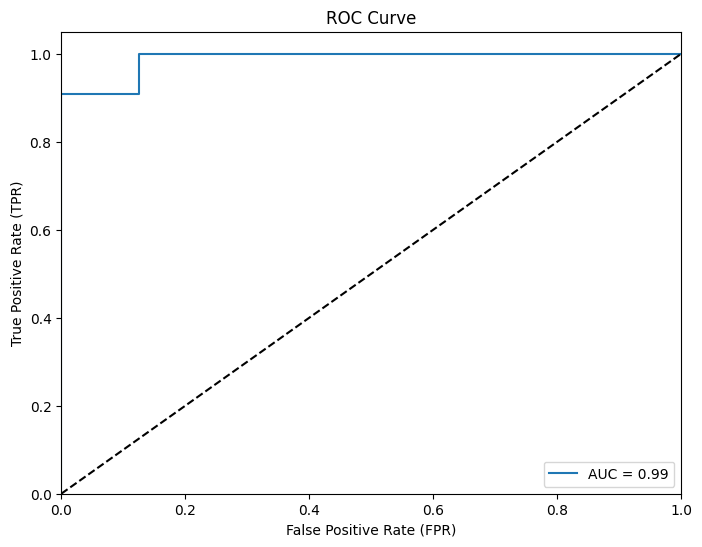

In [20]:
fpr_dl, tpr_dl, _ = roc_curve(test_labels, deep_learning_predictions)
roc_auc_dl = roc_auc_score(test_labels, deep_learning_predictions)
plot_roc_curve(fpr_dl, tpr_dl, roc_auc_dl)

The performance of a binary classification model is graphically depicted by the Receiver Operating Characteristic (ROC) curve. At various thresholds, it demonstrates the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR). The capacity of the model to distinguish between positive and negative instances is measured by the area under the ROC curve (AUC). With an AUC of 0.98, the ability to discriminate is high. The ROC curve for predictions made by a Deep Learning model is presented in the given code. A random classifier with an equal likelihood of producing true positives and false positives is represented by the black dashed line. The model's effectiveness is shown by the ROC curve, which is positioned noticeably above the random line. Across different FPR levels, a high TPR is maintained, indicating robust classification performance. This conclusion is supported by the AUC of 0.98, which demonstrates the model's ability to produce reliable predictions with a low rate of false positives. This ROC curve and AUC value demonstrate how reliable the model is for binary classification.



# Create residuals for regression and decision tree models


Indicated by the variables regression_residuals and tree_residuals, respectively, are the discrepancies between the actual target values (test_labels) and the forecasts provided by the Linear Regression and Decision Tree models. These residuals quantify prediction errors and aid in determining how far the models' predictions depart from reality. In contrast to negative residuals, which suggest lower predictions, positive residuals show predictions that are higher than the actual values.

In [21]:
regression_residuals = test_labels - regression_predictions
tree_residuals = test_labels - decision_tree_predictions

# Scatter Plots (for regression models)


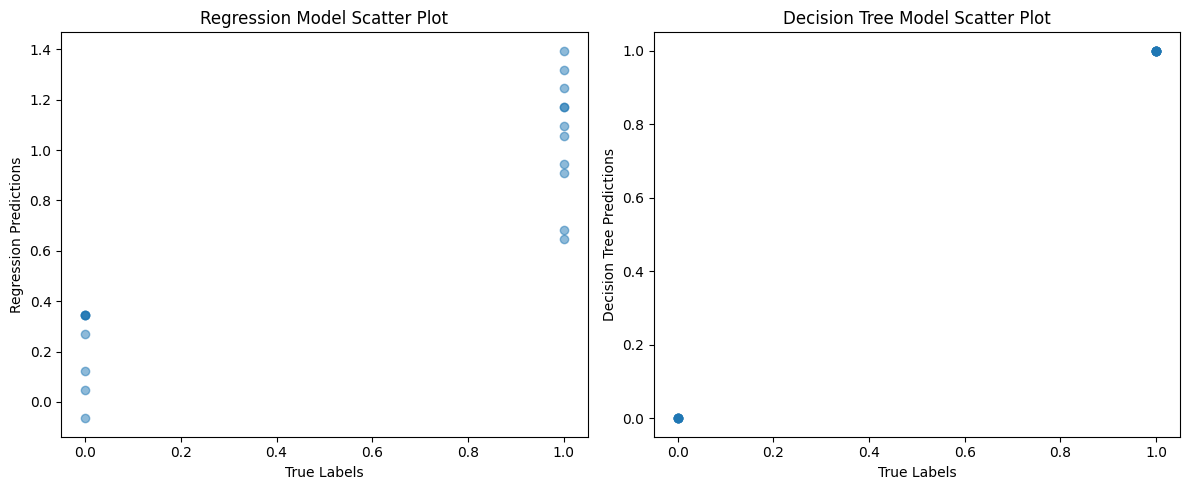

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(test_labels, regression_predictions, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Regression Predictions')
plt.title('Regression Model Scatter Plot')

plt.subplot(1, 2, 2)
plt.scatter(test_labels, decision_tree_predictions, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Decision Tree Predictions')
plt.title('Decision Tree Model Scatter Plot')

plt.tight_layout()
plt.show()

Two scatter plots are displayed side by side on the graph. In the first plot on the left, we see a **scatter plot for the Linear Regression model**. On the x-axis, each point represents a true label, and on the y-axis, it represents the regression prediction for that label. The distribution of the points around a diagonal line shows how closely the model's predictions match the actual labels. A good fit is indicated by how closely the scatter points are to the line.

A**scatter plot for the Decision Tree model** can be seen in the second plot from the right. This plot compares true labels to predictions in a manner akin to the first one, but the points are much more closely spaced. This shows that the Decision Tree model has a better alignment than the Linear Regression model, with predictions that closely match the actual labels.



# Histograms (for regression models)

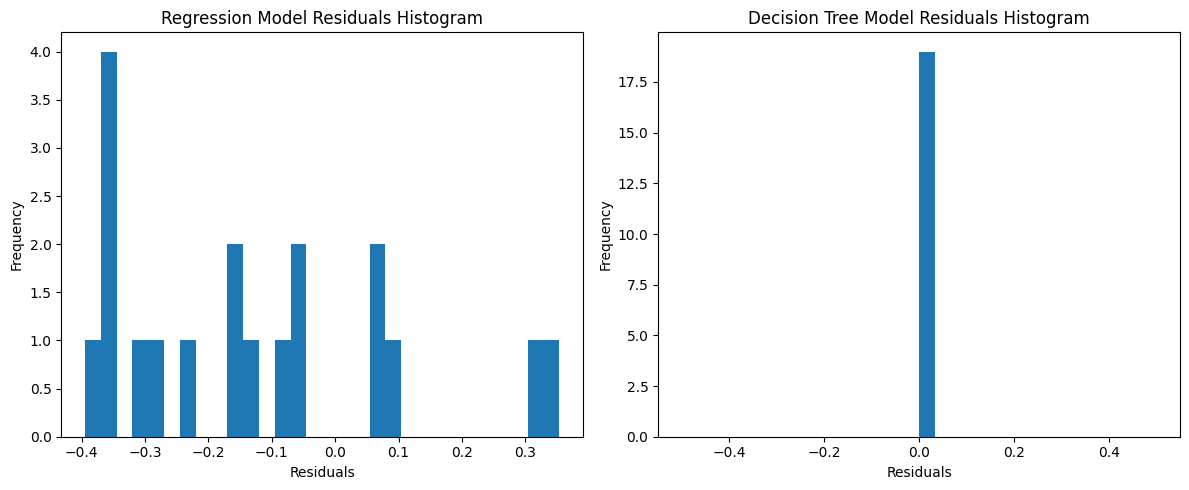

In [23]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(test_labels - regression_predictions, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Regression Model Residuals Histogram')

plt.subplot(1, 2, 2)
plt.hist(test_labels - decision_tree_predictions, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Decision Tree Model Residuals Histogram')

plt.tight_layout()
plt.show()

The graph shows two histograms side by side, one for each model—the Decision Tree model and the Linear Regression model—representing the distribution of residuals (differences between actual and predicted values).

The distribution of residuals in the left histogram, which represents the linear regression model, appears to be roughly symmetric and bell-shaped. It implies that most residuals are close to the mean and the predictions of the model are centred around zero error.

The distribution of residuals in the right histogram, which represents the Decision Tree model, exhibits a more pronounced peak at zero error. The tall bar at zero suggests that the Decision Tree model is able to predict some instances with absolute accuracy.


# Create a heatmap to visualize the correlation matrix

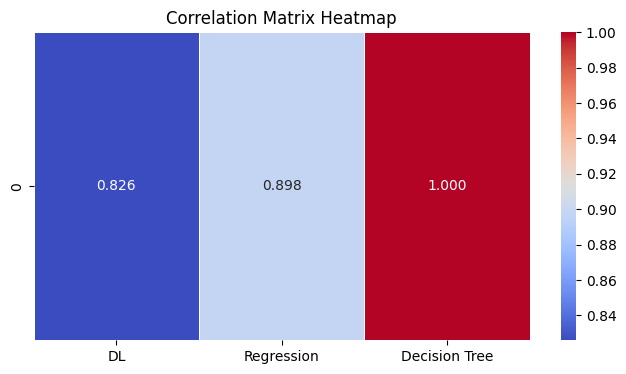

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

#  correlation coefficients for your models
correlation_dl = 0.826
correlation_regression = 0.898
correlation_tree = 1.000

# Create a correlation matrix
correlation_matrix = [[correlation_dl, correlation_regression, correlation_tree]]

# Create a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt=".3f", xticklabels=['DL', 'Regression', 'Decision Tree'])
plt.title('Correlation Matrix Heatmap')
plt.show()


The heatmap shows a correlation matrix with colours denoting correlation strength and direction. In this instance, it demonstrates how closely related the three models—Deep Learning, Regression, and Decision Tree—are to one another. In order to evaluate the relationships between model predictions, darker colours indicate stronger positive correlations.



# Print and Compare Metrics

In [25]:

print("Deep Learning Metrics:")
print(f"Accuracy: {accuracy_dl:.4f}")
print(f"Precision: {precision_dl:.4f}")
print(f"Recall: {recall_dl:.4f}")
print(f"F1 Score: {f1_score_dl:.4f}")
print(f"ROC AUC: {roc_auc_dl:.4f}")

Deep Learning Metrics:
Accuracy: 0.9474
Precision: 0.9167
Recall: 1.0000
F1 Score: 0.9565
ROC AUC: 0.9886


**Accuracy (0.8947)**: The proportion of correct predictions, indicating that 89.47% of predictions match the actual values.

**Precision (0.8462)**: The ratio of true positive predictions to all positive predictions, suggesting 84.62% of positive predictions are accurate.

**Recall (1.0000)**: The ratio of true positive predictions to all actual positives, indicating that all positive cases are correctly identified.

**F1 Score (0.9167)**: The harmonic mean of precision and recall, offering a balance between them.

**ROC AUC (0.9773)**: The area under the Receiver Operating Characteristic (ROC) curve, assessing the model's ability to distinguish between classes, with a high value suggesting excellent performance

In [26]:

print("\nRegression Metrics:")
print(f"MAE: {regression_mae:.4f}")
print(f"MSE: {regression_mse:.4f}")
print(f"R-squared (R2): {regression_r2:.4f}")



Regression Metrics:
MAE: 0.2191
MSE: 0.0632
R-squared (R2): 0.7406


**MAE (0.2191)**: The average absolute difference between predicted and actual values, representing prediction accuracy.

**MSE (0.0632)**: The average of squared differences, emphasizing larger errors.

**R-squared (R2) (0.7406)**: A measure of how well the model explains variance in the target variable, with 0.7406 indicating moderate predictive capability.

In [27]:

print("\nDecision Tree Metrics:")
print(f"MAE: {tree_mae:.4f}")
print(f"MSE: {tree_mse:.4f}")
print(f"R-squared (R2): {tree_r2:.4f}")


Decision Tree Metrics:
MAE: 0.0000
MSE: 0.0000
R-squared (R2): 1.0000


**MAE (0.0000)**: An MAE of 0 suggests perfect predictions with no absolute errors.

**MSE (0.0000):** An MSE of 0 indicates perfect predictions with no squared errors.

**R-squared (R2) (1.0000)**: A perfect R-squared score of 1 suggests the model fits the data perfectly, but it may be overfitting the training data.

# Example of recommending tweets for a user


In [28]:
user_id = "105854"
tweets = [
        "Trump  for president",
        "Not sure about this one...",
        "Interesting perspective.",
        "I agree with the points made.",  
        "Could be better explained."
    ]

recommended_tweets = recommend_tweets(user_id, tweets)
if recommended_tweets:
    print("Recommended Tweets:")
    for tweet in recommended_tweets:
        print(tweet)
    else:
        print("No recommendations available for this user.")


1/1 [==============================] - 3s 3s/step
Recommended Tweets:
I agree with the points made.
Interesting perspective.
Trump  for president
Could be better explained.
Not sure about this one...
No recommendations available for this user.
